In [2]:
%load_ext autoreload
%autoreload 2

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
import statistics
import os, sys
import healpy as hp
from tqdm.auto import tqdm, trange
import scipy.stats
import pandas as pd
from astropy.coordinates import SkyCoord
from scipy.stats import pearsonr
import warnings
from numpy import random
import time
import pickle
import networkx as nx
from itertools import combinations
import matplotlib, timeit
from matplotlib.patches import Ellipse
import plotly.graph_objects as go
import FoFCatalogMatching

import lsst.daf.persistence as dafPersist
import desc_dc2_dm_data
import lsst.geom
import lsst.afw.display as afwDisplay
import lsst.afw.display.rgb as rgb
from astropy.wcs import WCS
import random
from matplotlib_scalebar.scalebar import ScaleBar

All the functions from Shuang Liang have been written in the `code_shuang.py` file for readability of this notebook. \
This file can be found in the repertory `friendly/friendly`

In [18]:
sys.path.append('../')
import friendly.code_shuang as code_shuang

## 1) Load cosmoDC2 and DC2object catalogs

Load the truth and object catalogs from previously saved pickle files. \
In this notebook, the lower (respectively the upper) limit in magnitude is 18 (respectively 24.5) for both catalogs.

In [19]:
pkl_file = open('/sps/lsst/users/mramel/data/Catalogs_multiple_tracts/truth/truth_data_4026_friendly_mag.pkl', 'rb')
truth_data = pickle.load(pkl_file)

pkl_file2 = open('/sps/lsst/users/mramel/data/Catalogs_multiple_tracts/object/object_data_4026_friendly_mag.pkl', 'rb')
object_data = pickle.load(pkl_file2)

pkl_file3 = open('/sps/lsst/users/mramel/data/Catalogs_multiple_tracts/star_data_4026_friendly.pkl', 'rb')
stars_data = pickle.load(pkl_file3)

## 2) Apply the Friends-of-Friends algorithm

In [20]:
my_linking_length = 2.

In [21]:
results = FoFCatalogMatching.match(catalog_dict={'object':pd.DataFrame(object_data), 
                                                 'galaxy':pd.DataFrame(truth_data)}, linking_lengths=my_linking_length)

In [22]:
results = results.to_pandas()

## 3) Recover all the FoF groups and select one random group

In [23]:
results['is_object'] = (results['catalog_key']=='object')

In [24]:
res = results.drop('catalog_key', axis=1)

In [25]:
groups = []

for group_id, rows in res.groupby('group_id'):
    id_gal = list(rows['row_index'][~rows['is_object']])
    id_obj = list(rows['row_index'][rows['is_object']])
    groups.append([id_gal, id_obj])

In [122]:
group = [[],[]]
n = 3 #number of galaxies
m = 2 #number of objects

while (len(group[0]) != n) | (len(group[1]) != m): #choose which system you want to study
    group = groups[random.randint(0,len(groups))]

print(group)

[[13612, 29997, 167390], [178227, 178228]]


## 4) Draw the ellipses

### For the objects

In [150]:
# Indices of objects
idx2 = group[1]
print(idx2)

[178227, 178228]


In [151]:
# Calculate a,b,theta ellipse parameters (from the second moments)
Ixx = object_data['Ixx_pixel'][idx2]
Iyy = object_data['Iyy_pixel'][idx2]
Ixy = object_data['Ixy_pixel'][idx2]

x0 = object_data['x'][idx2]
y0 = object_data['y'][idx2]

a2, b2, theta2 = code_shuang.moments2ab(Ixx, Iyy, Ixy)

In [152]:
# Infos on each ellipse (x, y, a, b, theta)
keys = ['x', 'y', 'a', 'b', 'theta']
liste = [x0, y0, a2, b2, theta2]

obj_infos = {k:l for (k,l)in zip(keys, liste)}
obj_infos = pd.DataFrame(obj_infos, index=idx2)

print(obj_infos)

                   x             y         a         b       theta
178227  20597.415066  16740.100196  4.060314  2.539457  111.835892
178228  20605.133137  16733.907423  2.632052  2.308508   14.864216


In [153]:
# Calculate the A, B, C, D, E, E, F parameters
p_obj = pd.DataFrame(code_shuang.ab2AB(obj_infos['x'], obj_infos['y'], obj_infos['a'], obj_infos['b'], obj_infos['theta']))
print(p_obj)

         178227        178228
0  1.509753e+01  5.434403e+00
1  7.837467e+00  6.822508e+00
2  3.465514e+00 -3.963373e-01
3 -3.689831e+05 -1.053443e+05
4 -2.025806e+05 -1.060006e+05
5  1.099132e+10  3.944438e+09


### For the galaxies

In [154]:
# Indices of galaxies
idx1 = group[0]
print(idx1)

[13612, 29997, 167390]


In [155]:
# Measure the PSF by looking at stars
Ixx = stars_data['Ixx_pixel'][~np.isnan(stars_data['Ixx_pixel'])] ## in pixels
Iyy = stars_data['Iyy_pixel'][~np.isnan(stars_data['Iyy_pixel'])] ## in pixels

stars_data['r_gauss' ] = np.sqrt(np.log(2) * (Ixx+Iyy))

psf = np.median(stars_data['r_gauss']) * 0.2 / 3600    ## in degree; pixel ratio is 0.2"/pix
print(psf)

0.00011366832632830991


In [156]:
# Convert a, b, theta in (ra, dec, deg) plan to a, b, theta in (pixels) plan and convolute with the PSF
ra1 = truth_data['ra'][idx1] #in degrees
dec1 = truth_data['dec'][idx1] #in degrees

a = truth_data['size_true'][idx1] / 3600. #arcsec to degree
b = truth_data['size_minor_true'][idx1] / 3600. #arcsec to degree
a_eff = np.sqrt( a**2 + psf**2) #in degree (with the effect of the PSF)
b_eff = np.sqrt( b**2 + psf**2) #in degree (with the effect of the PSF)

a1 = a_eff * 3600 / 0.2 #in pixels (pixel ratio is 0.2"/pix)
b1 = b_eff * 3600 / 0.2 #in pixels (pixel ratio is 0.2"/pix)

theta1 = 270 - truth_data['position_angle_true'][idx1]
theta1[theta1>180] -= 180

In [157]:
# Calculate the positions of galaxies in pixels plan fron the position of one reference object
ra2 = object_data['ra'][idx2]
dec2 = object_data['dec'][idx2]

dx = (((ra2[0] - ra1) * np.cos(np.radians( (dec1+dec2[0]) / 2 )) * 3600 / 0.2)) #pixel displacement with respect to the position of the object #1 
dy = ((dec2[0] - dec1) * 3600 / 0.2)

In [158]:
# Infos on each ellipse (x, y, a, b, theta)
keys = ['x', 'y', 'a', 'b', 'theta']
liste = [x0[0]+dx, y0[0]-dy, a1, b1, theta1]

gal_infos = {k:l for (k,l)in zip(keys, liste)}
gal_infos = pd.DataFrame(gal_infos, index=idx1)

print(gal_infos)

                   x             y         a         b       theta
13612   20595.639315  16745.687028  2.272972  2.078743   47.979212
29997   20597.742076  16739.546571  2.277575  2.179738  135.856220
167390  20604.710211  16733.876240  2.191396  2.178008   31.619136


In [159]:
# Calculate the A, B, C, D, E, E, F parameters
p_gal = pd.DataFrame(code_shuang.ab2AB(gal_infos['x'], gal_infos['y'], gal_infos['a'], gal_infos['b'], gal_infos['theta']))
print(p_gal)

         13612         29997         167390
0  4.787657e+00  4.962786e+00  4.759798e+00
1  4.699917e+00  4.975818e+00  4.786137e+00
2 -4.203302e-01  2.179467e-01 -2.611494e-02
3 -9.156613e+04 -1.058705e+05 -9.763726e+04
4 -7.004636e+04 -8.778214e+04 -7.955254e+04
5  3.058838e+09  3.650127e+09  3.343010e+09


### Plot

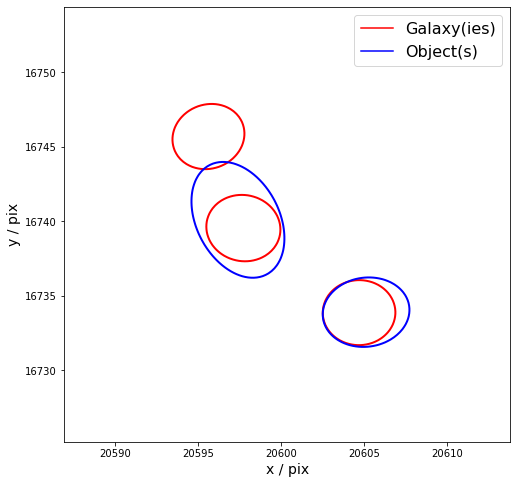

In [160]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111)
rough_size = 4*np.sqrt(gal_infos['a'][idx1[0]]*gal_infos['b'][idx1[0]])

for n in range(len(idx1)):
    code_shuang.plot_shape(gal_infos['x'][idx1[n]], gal_infos['y'][idx1[n]],
               rough_size, p_gal[idx1[n]], c='r', ls='-', ax=ax)    

for m in range(len(idx2)):
    code_shuang.plot_shape(obj_infos['x'][idx2[m]], obj_infos['y'][idx2[m]], rough_size, p_obj[idx2[m]], c='b', ls='-', ax=ax)

ax.set_xlabel('x / pix', fontsize=14)
ax.set_ylabel('y / pix', fontsize=14)

ax.plot([], [], 'r', label='Galaxy(ies)')
ax.plot([], [], 'b', label='Object(s)')
ax.legend(prop={'size':16})

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
xcenter = (xmin + xmax)/2
ycenter = (ymin + ymax)/2

## 5) Construct a NetworkX graph

### Construction of the graph

In [161]:
# Initialization
G = nx.Graph()

In [162]:
# Nodes
G.add_nodes_from(idx1, galaxy=True)
G.add_nodes_from(idx2, galaxy=False)
list(G.nodes(data=True))

[(13612, {'galaxy': True}),
 (29997, {'galaxy': True}),
 (167390, {'galaxy': True}),
 (178227, {'galaxy': False}),
 (178228, {'galaxy': False})]

In [163]:
# Edges = if the ellipses overlap, add an edge between them
p = pd.merge(p_gal, p_obj, how='outer', left_index=True, right_index=True) # group the ellipses parameters of the objects and galaxies

for i,j in combinations(G, 2):
    if code_shuang.is_overlapping(p[i], p[j]):
        G.add_edges_from([(j, i)])
        
list(G.edges)

[(13612, 178227), (29997, 178227), (167390, 178228)]

### Add purity on the nodes and overlap fraction on the edges

#### Purity

In [164]:
infos = pd.merge(gal_infos.T, obj_infos.T, how='outer', left_index=True, right_index=True) # group the ellipses parameters of the objects and galaxies

for flag in [True, False]:
    for n in [i for i in G if G.nodes[i]['galaxy']==flag]:
        info1 = infos[n]
        int_ = [code_shuang.gaussian_square_int(info1)]

        for c in list(G.adj[n]):
            if G.nodes[c]['galaxy']==flag:
                info2 = infos[c]
                int_.append(code_shuang.gaussian_overlap(info1, info2))

        purity = int_[0] /np.sum(int_)
        G.nodes[n]["purity"] = purity
        
list(G.nodes(data = True))

[(13612, {'galaxy': True, 'purity': 1.0}),
 (29997, {'galaxy': True, 'purity': 1.0}),
 (167390, {'galaxy': True, 'purity': 1.0}),
 (178227, {'galaxy': False, 'purity': 1.0}),
 (178228, {'galaxy': False, 'purity': 1.0})]

#### Overlap fraction

In [165]:
eps = 100
for edges in G.edges():
        
    x_center = np.mean([infos[edges[0]][0],infos[edges[1]][0]])
    y_center = np.mean([infos[edges[0]][1],infos[edges[1]][1]])
    
    A_ellipses, A_overlap = code_shuang.overlap_area_MC(p[edges[0]], p[edges[1]], [x_center-eps, x_center+eps], [y_center-eps, y_center+eps])
    fraction = A_overlap/A_ellipses
    
    G[edges[0]][edges[1]]['overlap'] = fraction
    G[edges[0]][edges[1]]['round_overlap'] = round(fraction, 3)

list(G.edges(data=True))

[(13612, 178227, {'overlap': 0.005998286203941732, 'round_overlap': 0.006}),
 (29997, 178227, {'overlap': 0.4747847478474784, 'round_overlap': 0.475}),
 (167390, 178228, {'overlap': 0.78125, 'round_overlap': 0.781})]

## 6) Plot the NetworkX graph vs. simulated image in colors

In [166]:
butler = dafPersist.Butler('/sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr3-v1-grizy/')
skymap = butler.get('deepCoadd_skyMap')
patch = object_data['patch'][idx2][0]
dataId = {'tract':4026, 'patch': patch, 'filter':'i'}

lsst.CameraMapper INFO: Loading exposure registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/registry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/CALIB/calibRegistry.sqlite3
LsstCamMapper WARN: Unable to find valid calib root directory


In [167]:
cutout_size_x = int(xmax - xmin)
cutout_size_y = int(ymax - ymin)

if cutout_size_x%2 != 0:
    cutout_size_x += 1
    
if cutout_size_y%2 != 0:
    cutout_size_y += 1
    
X = cutout_size_x/(2*x_center)
Y = cutout_size_y/(2*y_center)

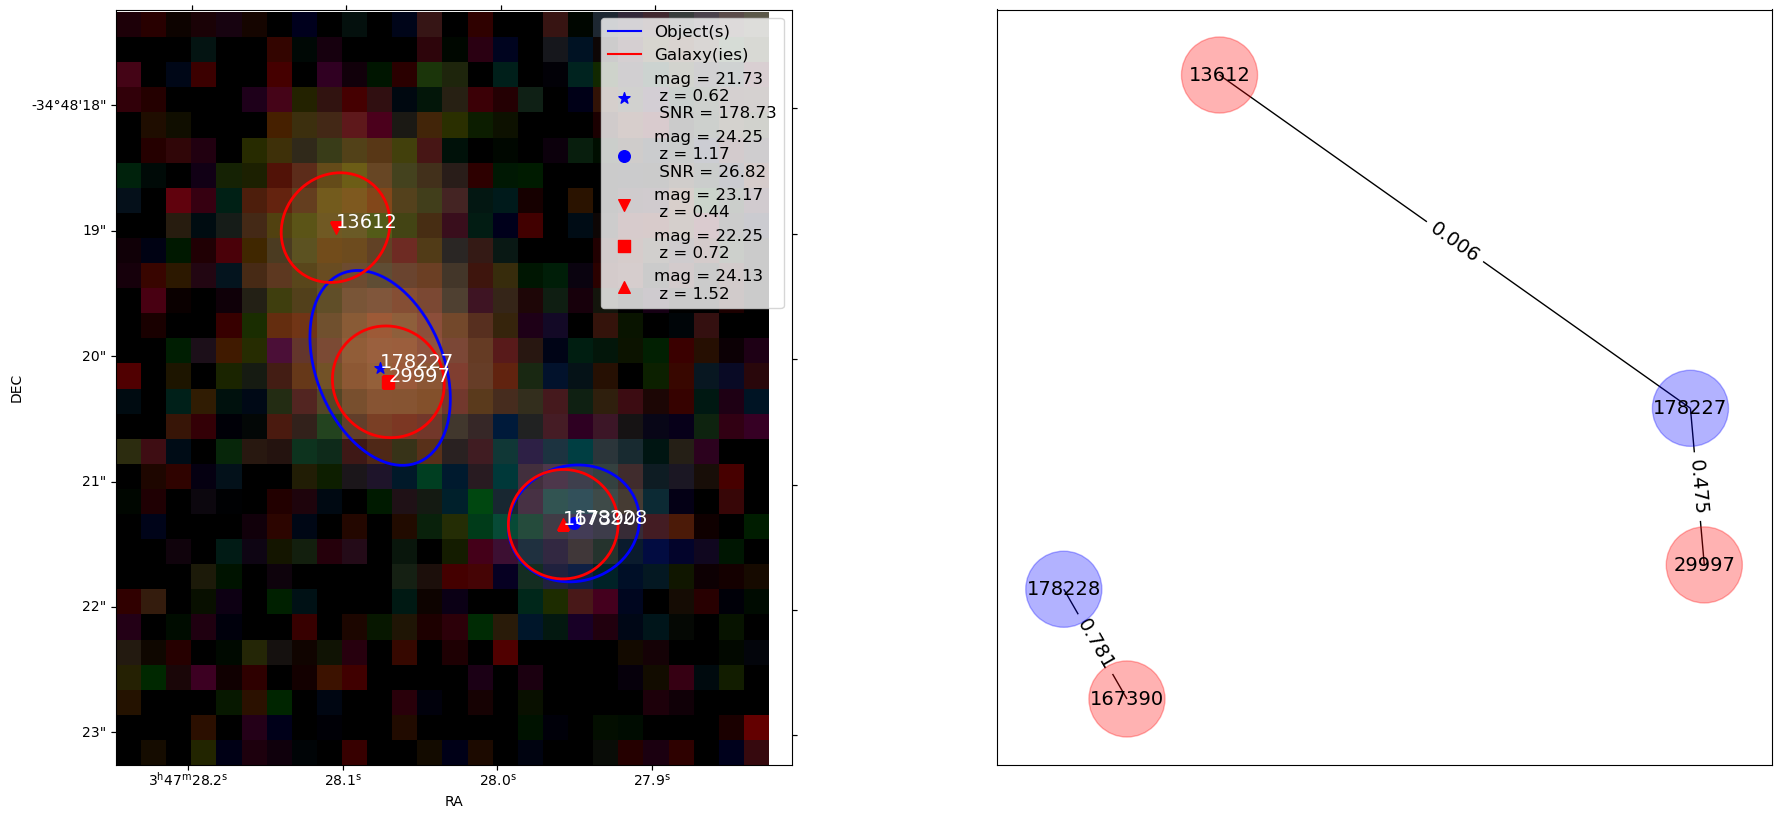

In [168]:
markers = ['*', 'o', 'v', 's', '^', 'P']

cutout_extent = lsst.geom.ExtentI(cutout_size_x, cutout_size_y)

############################################################################

if np.floor(xcenter) - np.round(xcenter) != 0:
    xcenter = xcenter + 1

if np.floor(ycenter) - np.round(ycenter) != 0:
    pix_center_y = ycenter + 1

############################################################################

bbox = lsst.geom.BoxI(lsst.geom.Point2I((xcenter - cutout_size_x*0.5, ycenter - cutout_size_y*0.5)), cutout_extent)

cutout = butler.get("deepCoadd_sub", dataId=dataId, bbox=bbox)
cutouts = [butler.get("deepCoadd_sub", bbox=bbox, tract=4026, patch=patch, filter=band) for band in "irg"]

wcs = cutout.getWcs()
off = lsst.geom.Extent2D(-(xcenter - cutout_size_x*0.5), -(ycenter - cutout_size_y*0.5))
wcs_new = wcs.copyAtShiftedPixelOrigin(off)
wcs_fits_meta = wcs_new.getFitsMetadata()

image_arr = cutouts[0].getMaskedImage().getImage().array
image_rgb = rgb.makeRGB(*cutouts, dataRange=1, Q=10)
del cutouts  # let gc save some memory for us

############################################################################

fig, ax = plt.subplots(1, 2, figsize=(22, 10), dpi=100)

plt.subplot(121, projection=WCS(wcs_fits_meta))
plt.imshow(image_rgb, origin='lower')

plt.plot([], [], 'b', label='Object(s)')
plt.plot([], [], 'r', label='Galaxy(ies)')

for i in range(0, len(idx2)):
    diff_x = obj_infos['x'][idx2[i]] - xcenter 
    diff_y = obj_infos['y'][idx2[i]] - ycenter 
    
    p_obj = code_shuang.ab2AB(obj_infos['x'][idx2[i]]* X + diff_x, obj_infos['y'][idx2[i]]* Y + diff_y, obj_infos['a'][idx2[i]], obj_infos['b'][idx2[i]], obj_infos['theta'][idx2[i]])
    code_shuang.plot_shape(obj_infos['x'][idx2[i]]* X + diff_x, obj_infos['y'][idx2[i]]* Y + diff_y, rough_size, p_obj, c='b', ls='-', ax=ax[0])
    
    plt.scatter(obj_infos['x'][idx2[i]]* X + diff_x, obj_infos['y'][idx2[i]]* Y + diff_y, marker=markers[i], c='b', s=70,
              label='mag = ' + str(round(float(object_data['mag_i_cModel'][idx2[i]]),2)) + '\n z = ' + str(round(float(object_data['photoz_mean'][idx2[i]]),2)) + '\n SNR = ' + str(round(float(object_data['snr_i_cModel'][idx2[i]]),2)))
    plt.text(obj_infos['x'][idx2[i]]* X + diff_x, obj_infos['y'][idx2[i]]* Y + diff_y, str(idx2[i]), c='white', fontsize=14)

for j in range(len(idx1)):
    diff_x = gal_infos['x'][idx1[j]] - xcenter
    diff_y = gal_infos['y'][idx1[j]] - ycenter
    
    p_gal = code_shuang.ab2AB(gal_infos['x'][idx1[j]] * X + diff_x, gal_infos['y'][idx1[j]]* Y + diff_y, gal_infos['a'][idx1[j]], gal_infos['b'][idx1[j]], gal_infos['theta'][idx1[j]]) 
    code_shuang.plot_shape(gal_infos['x'][idx1[j]]* X + diff_x, gal_infos['y'][idx1[j]]* Y + diff_y, rough_size, p_gal, c='r', ls='-', ax=ax[0])
    
    plt.scatter(gal_infos['x'][idx1[j]] * X + diff_x, gal_infos['y'][idx1[j]]* Y + diff_y, marker=markers[len(idx2)+j], c='r', s=70,
              label='mag = ' + str(round(float(truth_data['mag_i'][idx1[j]]),2)) + '\n z = ' + str(round(float(truth_data['redshift'][idx1[j]]),2)))
    plt.text(gal_infos['x'][idx1[j]] * X + diff_x, gal_infos['y'][idx1[j]]* Y + diff_y, str(idx1[j]), c='white', fontsize=14)
    
plt.xlabel("RA")
plt.ylabel("DEC")

plt.legend(prop={'size':12}, loc='best')
plt.gca().set_aspect('equal')
############################################################################

plt.subplot(122)
pos = nx.spring_layout(G, seed=9, weight='overlap')
color_map = ['red' if G.nodes[k]['galaxy'] == True else 'blue' for k in list(G.nodes)]  

nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=3000, node_shape='o', alpha=0.3)
nx.draw_networkx_edges(G, pos)

nx.draw_networkx_labels(G, pos, font_size=14, font_weight='normal')
edge_labels = nx.get_edge_attributes(G, "round_overlap")
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=14);

## 7) Cut in the overlap fraction

In [169]:
# Cut in the overlap fraction
cut = 0.05

In [170]:
for i, j in G.edges():
    if G[i][j]['overlap'] < cut:
        G.remove_edge(i,j)

In [171]:
list(G.edges(data=True))

[(29997, 178227, {'overlap': 0.4747847478474784, 'round_overlap': 0.475}),
 (167390, 178228, {'overlap': 0.78125, 'round_overlap': 0.781})]

## 8) Identify an isolate new groups

In [172]:
# Number of subgroups based on the NetworkX graph
nx.number_connected_components(G)

3

In [173]:
new_group = []
for S in [G.subgraph(c) for c in nx.connected_components(G)]:
    gal = []
    obj = []
    for i in S.nodes():    
        if S.nodes[i]['galaxy']:
            gal.append(i)
        else:
            obj.append(i)
    new_group.append([gal, obj])

In [174]:
print(new_group)

[[[13612], []], [[29997], [178227]], [[167390], [178228]]]
